In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')
import warnings
warnings.filterwarnings('ignore')
import yfinance as yf
from pandas_datareader import data as pdr
from pmdarima.arima import auto_arima
from pmdarima.arima import ADFTest
import statsmodels.api as sm
from sklearn.metrics import r2_score
from fastai.tabular.all import add_datepart
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor
import math
import time

tic = time.time()

In [2]:
# # read the stock data at the first run
# # to download the data, need the vpn
# # comment the following codes after the first run
# yf.pdr_override()
# data = pdr.get_data_yahoo("MSFT", start="2022-01-01", end="2023-05-30")
# data # there are 352 data in total using as training and validation data
# # data.to_csv('/Users/jennyhuang/Documents/jobs/DBC-AI-Launch/project1-StockPrediction/MSFT.csv')

In [3]:
data = pd.read_csv('/Users/jennyhuang/Documents/jobs/DBC-AI-Launch/project1-StockPrediction/MSFT.csv')
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 352 entries, 2022-01-03 to 2023-05-26
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       352 non-null    float64
 1   High       352 non-null    float64
 2   Low        352 non-null    float64
 3   Close      352 non-null    float64
 4   Adj Close  352 non-null    float64
 5   Volume     352 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 19.2 KB


In [4]:
data_2 = pd.DataFrame({'Close':data['Close']})
data_2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 352 entries, 2022-01-03 to 2023-05-26
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   352 non-null    float64
dtypes: float64(1)
memory usage: 5.5 KB


In [5]:
data_2.asfreq("D")[:15]

,Close
Date,
2022-01-03,334.750000
2022-01-04,329.010010
2022-01-05,316.380005
2022-01-06,313.880005
2022-01-07,314.040009
2022-01-08,NaN
2022-01-09,NaN
2022-01-10,314.269989
2022-01-11,314.980011


In [6]:
data_2.asfreq("D", method="ffill")[:15]

,Close
Date,
2022-01-03,334.750000
2022-01-04,329.010010
2022-01-05,316.380005
2022-01-06,313.880005
2022-01-07,314.040009
2022-01-08,314.040009
2022-01-09,314.040009
2022-01-10,314.269989
2022-01-11,314.980011


In [7]:
data_2 = data_2.asfreq("D", method='ffill')
data_2

,Close
Date,
2022-01-03,334.750000
2022-01-04,329.010010
2022-01-05,316.380005
2022-01-06,313.880005
2022-01-07,314.040009
...,...
2023-05-22,321.179993
2023-05-23,315.260010
2023-05-24,313.850006


<Axes: xlabel='Date'>

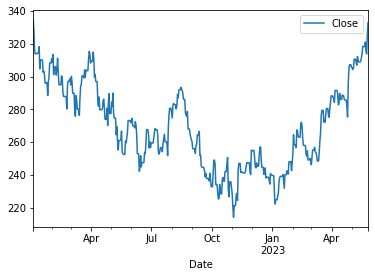

In [8]:
data_2.plot()

In [9]:
# Testing for stationarity
adf_test = ADFTest(alpha = 0.05)
adf_test.should_diff(data_2)

(0.9571381685274963, True)

In [10]:
# Spliting the dataset into train and test
train, test = data_2[:int(len(data_2)*0.9)].copy(), data_2[int(len(data_2)*0.9):].copy()

In [11]:
len(test)

51

In [12]:
train.tail()

,Close
Date,
2023-04-01,288.299988
2023-04-02,288.299988
2023-04-03,287.230011
2023-04-04,287.179993
2023-04-05,284.339996


In [13]:
test.head()

,Close
Date,
2023-04-06,291.600006
2023-04-07,291.600006
2023-04-08,291.600006
2023-04-09,291.600006
2023-04-10,289.390015


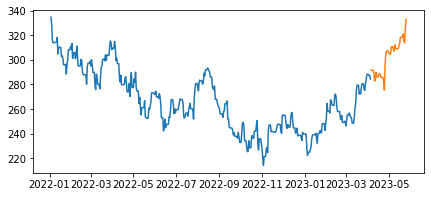

In [14]:
plt.figure(figsize=(7,3))
# plt.figure()
plt.plot(train)
plt.plot(test)
plt.savefig('/Users/jennyhuang/Documents/jobs/DBC-AI-Launch/project1-StockPrediction/train-test')

In [15]:
arima_model =  auto_arima(train,start_p=0, d=1, start_q=0, 
                          max_p=5, max_d=5, max_q=5, start_P=0, 
                          D=1, start_Q=0, max_P=5, max_D=5,
                          max_Q=5, m=12, seasonal=True, 
                          error_action='warn',trace = True,
                          supress_warnings=True,stepwise = True,
                          random_state=20,n_fits = 50 )

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=2935.096, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=2820.311, Time=0.18 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.67 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=2935.710, Time=0.04 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=2782.549, Time=0.35 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=2764.478, Time=0.69 sec
 ARIMA(1,1,0)(4,1,0)[12]             : AIC=2740.963, Time=1.13 sec
 ARIMA(1,1,0)(5,1,0)[12]             : AIC=2735.840, Time=2.44 sec
 ARIMA(1,1,0)(5,1,1)[12]             : AIC=inf, Time=11.66 sec
 ARIMA(1,1,0)(4,1,1)[12]             : AIC=inf, Time=6.90 sec
 ARIMA(0,1,0)(5,1,0)[12]             : AIC=2733.953, Time=2.19 sec
 ARIMA(0,1,0)(4,1,0)[12]             : AIC=2739.147, Time=0.90 sec
 ARIMA(0,1,0)(5,1,1)[12]             : AIC=inf, Time=10.33 sec
 ARIMA(0,1,0)(4,1,1)[12]             : AIC=inf, Time=6.41 sec
 ARIMA(0,1,1)(5,1,0)[12]             : AIC

In [16]:
par_map = arima_model.get_params()
a, b, c = par_map['order'][0], par_map['order'][1], par_map['order'][2]

In [17]:
# check the Best model: ARIMA(1,1,1)(5,1,0)[12]
model = sm.tsa.arima.ARIMA(train, order=(a, b, c))
fitted = model.fit()
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  458
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1358.246
Date:                Mon, 19 Jun 2023   AIC                           2722.491
Time:                        20:44:46   BIC                           2734.865
Sample:                    01-03-2022   HQIC                          2727.365
                         - 04-05-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9100      0.102      8.942      0.000       0.711       1.109
ma.L1         -0.9407      0.082    -11.478      0.000      -1.101      -0.780
sigma2        22.3366      1.104     20.224      0.0

In [18]:
# Summary of the model
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  458
Model:             SARIMAX(1, 1, 1)x(5, 1, [], 12)   Log Likelihood               -1358.560
Date:                             Mon, 19 Jun 2023   AIC                           2733.121
Time:                                     20:44:46   BIC                           2765.905
Sample:                                 01-03-2022   HQIC                          2746.048
                                      - 04-05-2023                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9541      0.033     28.691      0.000       0.889       1.019
ma.L1         -0.9897      0.021    -46.292      0.000      -1.032      -0.948
ar.S.L12      -0.7778      0.050    -15.553      0.000      -0.876      -0.680
ar.S.L24      -0.5913      0.059     -9.985      0.000      -0.707      -0.475
ar.S.L36      -0.4543      0.062     -7.367      0.000      -0.575      -0.333
ar.S.L48      -0.3400      0.067     -5.099      0.000      -0.471      -0.209
ar.S.L60      -0.1288      0.052     -2.477      0.013      -0.231      -0.027
sigma2        25.5300      1.548     16.492      0.000      22.496      28.564
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 9.78
Prob(Q):                              0.97   Prob(JB):                         0.01
Heteroskedasticity (H):               0.68   Skew:                            -0.04
Prob(H) (two-sided):                  0.02   Kurtosis:                         3.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [19]:
prediction = pd.DataFrame(arima_model.predict(n_periods = 51),index=test.index)
prediction.columns = ['predicted_price']
prediction.tail()

,predicted_price
Date,
2023-05-22,292.182701
2023-05-23,291.503017
2023-05-24,291.686450
2023-05-25,293.700427
2023-05-26,294.759342


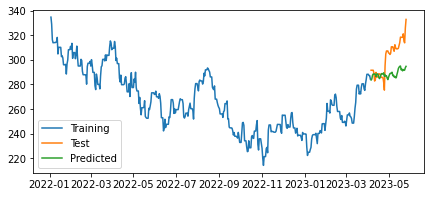

In [20]:
plt.figure(figsize=(7,3))
plt.plot(train,label="Training")
plt.plot(test,label="Test")
plt.plot(prediction,label="Predicted")
plt.legend(loc = 'best')
# plt.savefig('/Users/jennyhuang/Documents/jobs/DBC-AI-Launch/project1-StockPrediction/test/TimeSeries_Auto-ARIMA/prediction.png')

In [21]:
test['predicted_price'] = prediction
r2_score(test['Close'], test['predicted_price'])

-0.768179282040655

In [22]:
prediction = pd.DataFrame(arima_model.predict(n_periods = 7))
prediction.columns = ['predicted_price']
print(prediction.to_latex())
prediction

\begin{tabular}{lr}
\toprule
{} &  predicted\_price \\
\midrule
2023-04-06 &       283.661155 \\
2023-04-07 &       284.415385 \\
2023-04-08 &       287.513460 \\
2023-04-09 &       288.498542 \\
2023-04-10 &       288.417741 \\
2023-04-11 &       288.621336 \\
2023-04-12 &       288.332138 \\
\bottomrule
\end{tabular}



,predicted_price
2023-04-06,283.661155
2023-04-07,284.415385
2023-04-08,287.513460
2023-04-09,288.498542
2023-04-10,288.417741
2023-04-11,288.621336
2023-04-12,288.332138


In [23]:
# final result for future 7 days
prediction = pd.DataFrame(arima_model.predict(n_periods = 58))
prediction.columns = ['predicted_price']
prediction.tail(7)

,predicted_price
2023-05-27,296.917834
2023-05-28,298.577198
2023-05-29,299.592031
2023-05-30,300.633603
2023-05-31,297.827603
2023-06-01,298.597201
2023-06-02,297.438011


In [24]:
real = data.loc['2023-05-26', 'Close']
pred = prediction.loc['2023-06-02', 'predicted_price']
perc = (pred - real) / real * 100
print("The precentage of the future 7th day's price is higher than the prediction day is {0:.2f}%".format(perc))

The precentage of the future 7th day's price is higher than the prediction day is -10.65%


In [25]:
toc = time.time()
print("Total running time is {0:.2f} min".format((toc - tic) / 60))

Total running time is 3.07 min
